In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from seaborn import color_palette, palettes
from matplotlib import colormaps as cm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [ ]:
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv")
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')

In [ ]:
train.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


The Date time objects in the csv files are read as a string object rather than a date time object and it’s very tough to perform operations like time difference on a string rather than a dt object. Pandas to_datetime() method helps to convert string dt into Python dt object:

In [ ]:
train["date"] = pd.to_datetime(train.date)
transactions["date"] = pd.to_datetime(transactions.date)
holidays["date"] = pd.to_datetime(holidays.date)
oil["date"] = pd.to_datetime(oil.date)

In [ ]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Since each column except the 'id' has excactly one missing value, all of those NaNs might be in a one specific row.

In [ ]:
rows_with_null = train[train['sales'].isnull()] # Let's check for the 'sales' column.
rows_with_null

,id,date,store_nbr,family,sales,onpromotion


In [ ]:
train.shape

(3000888, 6)

The assumption is correct, so imputing those values does not make sens and the best way to deal with it is to just drop all row.

In [ ]:
train.dropna(subset=['sales'], inplace=True)
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

# 1. TRANSACTIONS

transactions.csv is the dataset containing date, store number and the number of transactions per store


In [ ]:
transactions.head(10)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [ ]:
transactions = transactions.sort_values(["store_nbr", "date"])
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

No missing data in transactions data set.

# Monthly transactions

In [ ]:
trans = transactions.copy()
trans["year"] = trans.date.dt.year
trans["month"] = trans.date.dt.month
trans["dayofweek"] = trans["date"].dt.dayofweek + 1

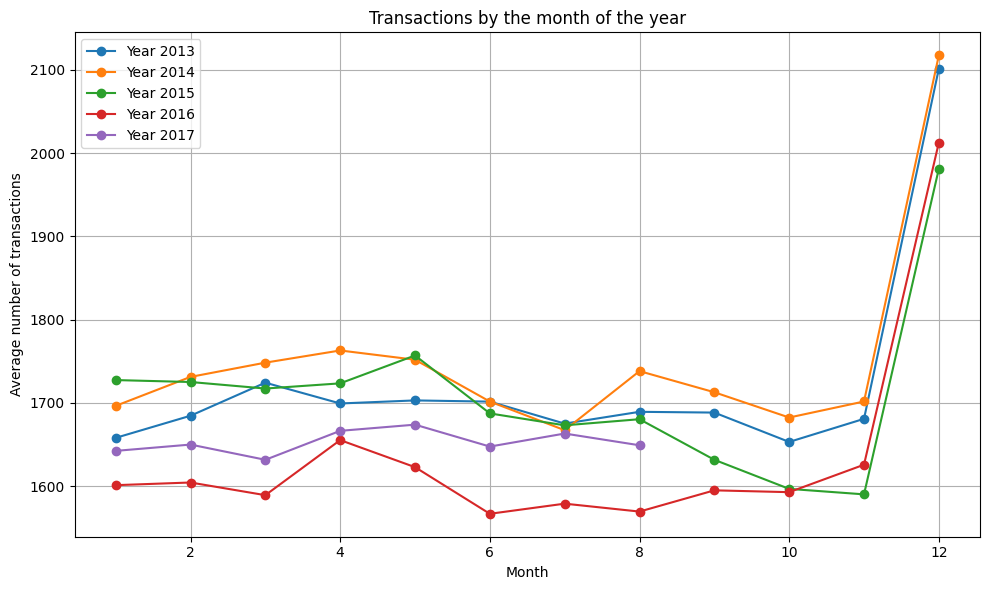

In [ ]:
monthly_transactions = trans.groupby(["year", "month"])["transactions"].mean().reset_index()

plt.figure(figsize=(10,6))
for year in monthly_transactions["year"].unique():
  plt.plot(monthly_transactions[monthly_transactions["year"] == year]["month"],
             monthly_transactions[monthly_transactions["year"] == year]["transactions"],
             marker='o', linestyle='-', label=f'Year {year}')

plt.title('Transactions by the month of the year')
plt.xlabel('Month')
plt.ylabel('Average number of transactions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Sharp increase in transactions around December can be observed for each year. It might be connected with some Christmas events happening around this month.

# Weekly transactions

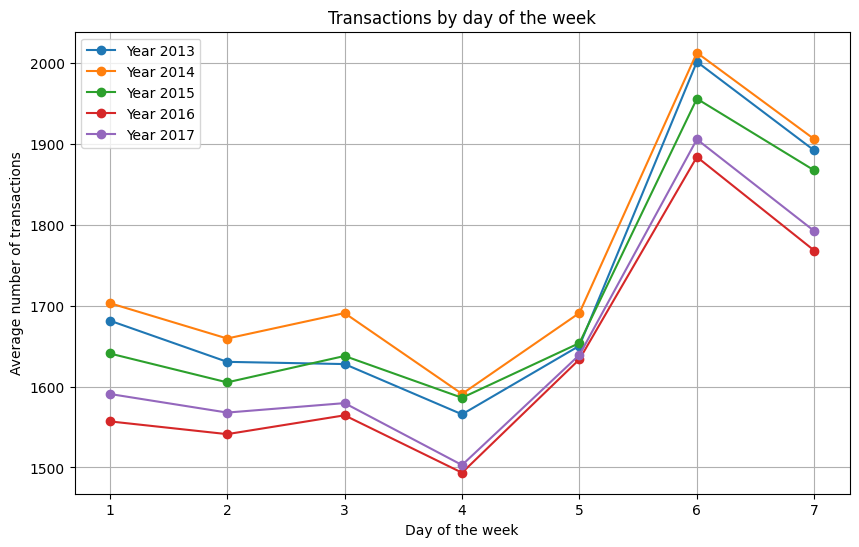

In [ ]:
weekly_transactions = trans.groupby(["year", "dayofweek"])["transactions"].mean().reset_index()

plt.figure(figsize=(10, 6))
for year in weekly_transactions["year"].unique():
    plt.plot(weekly_transactions[weekly_transactions["year"] == year]["dayofweek"],
             weekly_transactions[weekly_transactions["year"] == year]["transactions"],
             marker='o', linestyle='-', label=f'Year {year}')

plt.title('Transactions by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average number of transactions')
plt.legend()
plt.grid(True)
plt.show()

The stable pattern can be observed in the number of transactions per day of the week for each year. The most transactions are made at weekends.

# 2. Stores


stores.csv file store metadata, including city, state, type, and cluster, where cluster is a grouping of similar stores.

In [ ]:
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [ ]:
stores.head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


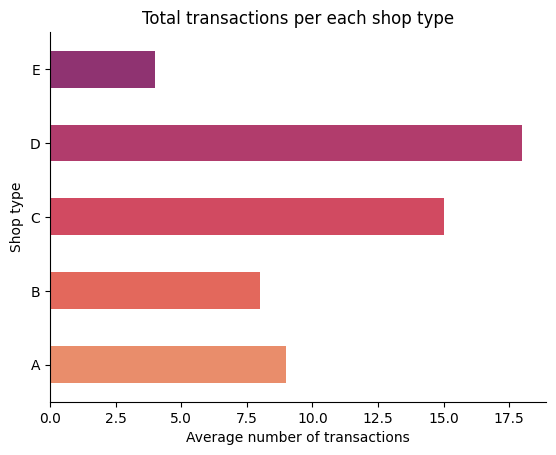

In [ ]:
stores.groupby('type').size().plot(kind='barh', color=sns.color_palette("flare"))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Total transactions per each shop type')
plt.xlabel('Average number of transactions')
plt.ylabel('Shop type')
plt.show()

# Total sales per each store

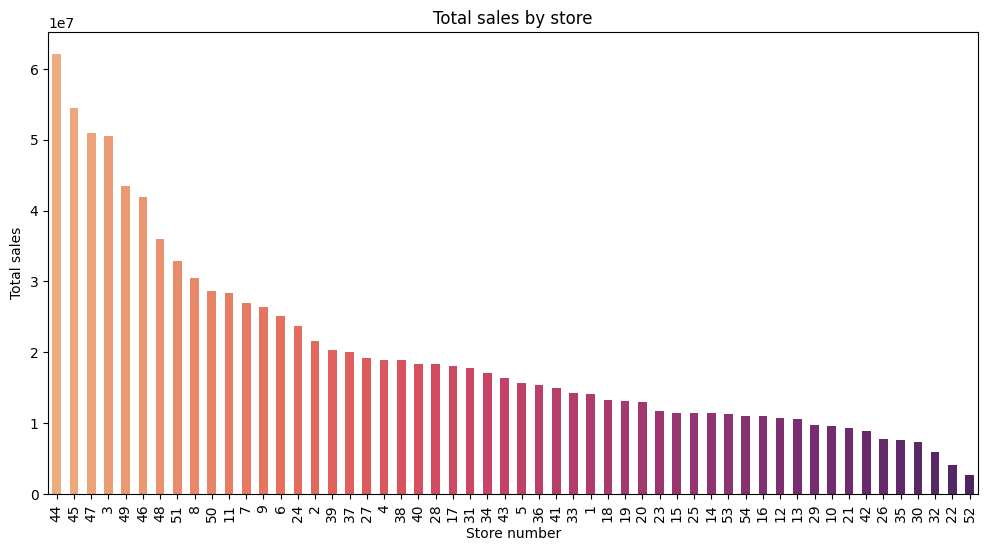

In [ ]:
plt.figure(figsize=(12, 6))
sales_per_store = train.groupby('store_nbr').sales.sum().sort_values(ascending=False)
sales_per_store.plot(kind='bar', color=sns.color_palette("flare", len(sales_per_store)))
plt.title('Total sales by store')
plt.xlabel('Store number')
plt.ylabel('Total sales')
plt.show()

# Sales by the family of products

family column identifies the type of product sold

Text(0.5, 0, 'Sales')

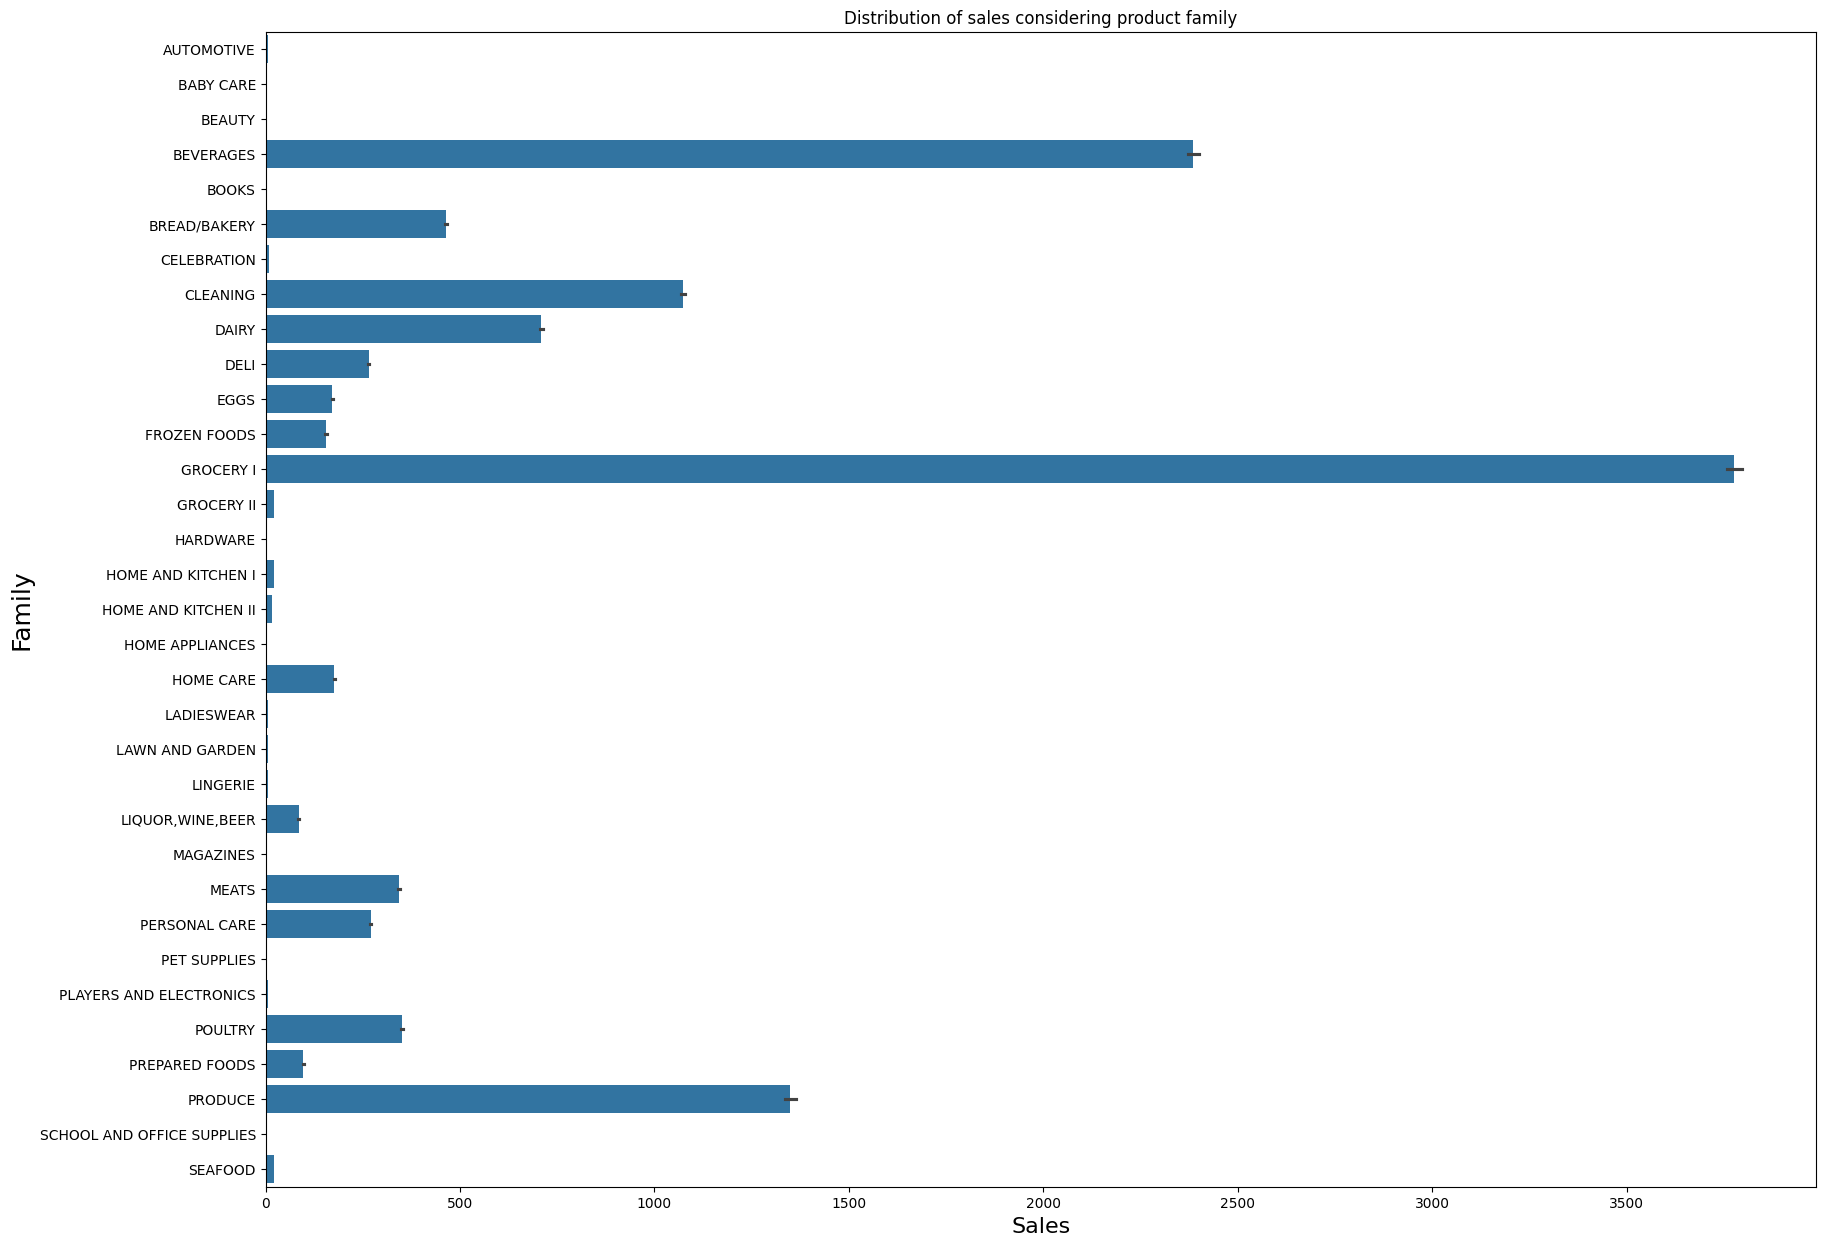

In [ ]:
plt.figure(figsize=(20, 15))

sns.barplot(x='sales',y='family',data=train)
plt.title('Distribution of sales considering product family')
plt.ylabel('Family', fontsize=18)
plt.xlabel('Sales', fontsize=16)

# 3. Oil Prices and it´s influence on sales

oil.csv dataset contains daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [ ]:
oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


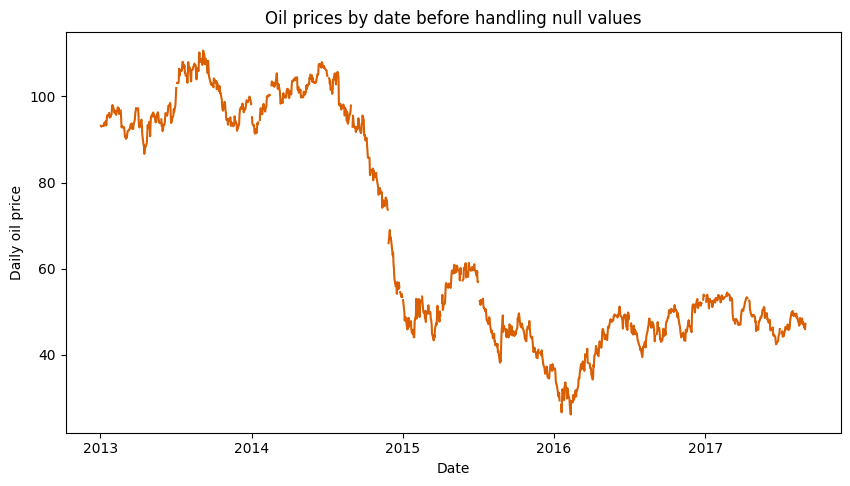

In [ ]:
def plot_series(series):
    plt.plot(series['date'], series['dcoilwtico'], color=sns.color_palette('Dark2')[1])
    plt.xlabel('Date')
    plt.ylabel('Daily oil price')

plt.figure(figsize=(10, 5.2))
df_sorted = oil.sort_values('date')
plot_series(df_sorted)
plt.title('Oil prices by date before handling null values')
plt.show()

In [ ]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

Some missing data are present in oil dataset, so it is crucial to handle somehow those null values before making any predictions. In this case, the backfill strategy, which filled in missing values with the next available value in the column, were used.

In [ ]:
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='backfill')

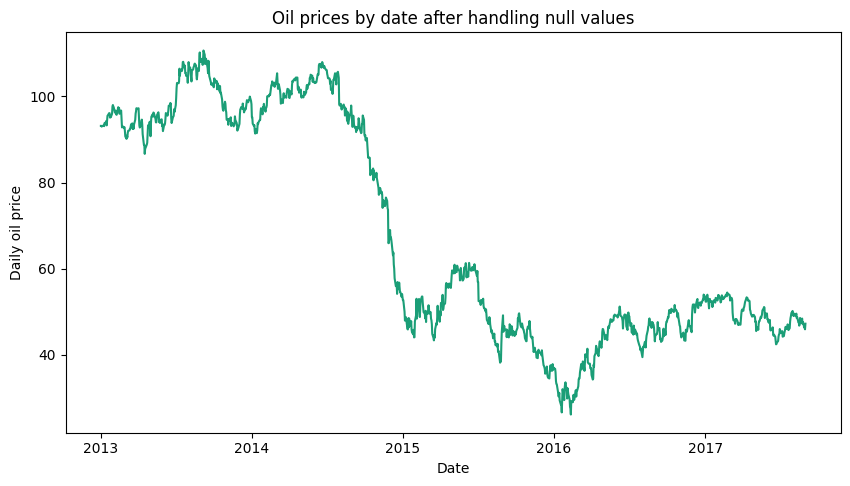

In [ ]:
def plot_series(series):
    palette = sns.color_palette('Dark2')
    plt.plot(series['date'], series['dcoilwtico'], color=palette[0])
    plt.xlabel('Date')
    plt.ylabel('Daily oil price')

plt.figure(figsize=(10, 5.2))
df_sorted = oil.sort_values('date')
plot_series(df_sorted)
plt.title('Oil prices by date after handling null values')
plt.show()

# 4. Holiday events - How specific holiday events affect sales?

holidays_events.csv file contain holidays and events, with metadata
NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [ ]:
holidays.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


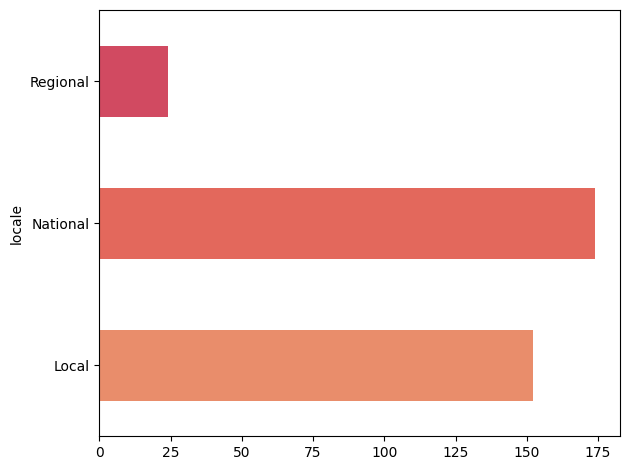

In [ ]:
holidays.groupby('locale').size().plot(kind='barh', color=sns.color_palette("flare"))
plt.tight_layout()
plt.show()

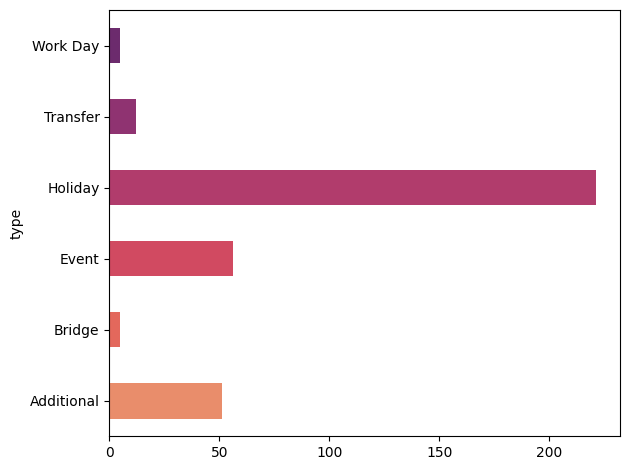

In [ ]:
holidays.groupby('type').size().plot(kind='barh', color=sns.color_palette("flare"))
plt.tight_layout()
plt.show()

<Axes: ylabel='transferred'>

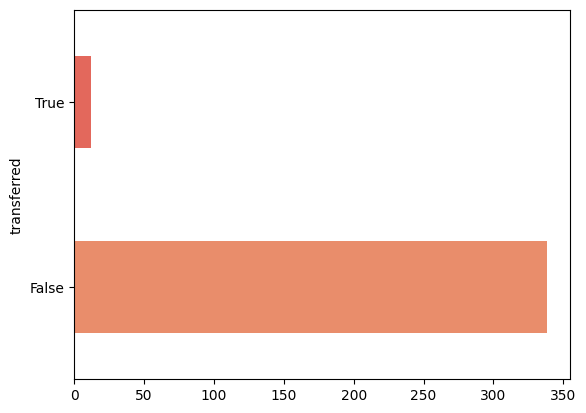

In [ ]:
holidays.groupby('transferred').size().plot(kind='barh', color=sns.color_palette("flare"))

In [ ]:
holidays['transferred'] = holidays['transferred'].replace({True: 1, False: 0})

transferred_perc = (holidays['transferred'] == 1).sum() / len(holidays) * 100
transferred_perc

3.428571428571429

Note: Only the small fraction(about 3%) of all holiday events were transferred, so we can get rid of the ones transferred from our dataset.

# 6. Data Preprocessing

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Merging the data sets - data were combined on common columns or indices. Both the initial datasets need to have a common key column on which the DataFrames would be joined.

In [ ]:
df1 = train.merge(stores, on='store_nbr', how='inner')
df2 = df1.merge(transactions, on=['store_nbr', 'date'], how='inner')
df3 = df2.merge(holidays, on='date', how='inner')
train_merg = df3.merge(oil, on='date', how='inner')
train_merg.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,0,97.01
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,0,97.01
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,0,97.01
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,0,97.01
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,0,97.01


In [ ]:
train_merg.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type_x          0
cluster         0
transactions    0
type_y          0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

Let us save merged data set so it can be used to create power bi dashboard.

In [ ]:
train_merg.to_csv('visualise_df.csv', index=False)

In [ ]:
train_merg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

In [ ]:
train_merg = train_merg.rename(columns={'type_x': 'store_type', 'type_y': 'holiday_type'})

In [ ]:
train_merg.describe()

,id,store_nbr,sales,onpromotion,cluster,transactions,transferred,dcoilwtico
count,3.220470e+05,322047.000000,322047.000000,322047.000000,322047.000000,322047.000000,322047.000000,322047.000000
mean,1.682979e+06,26.994672,406.383452,3.727136,8.531202,1734.117840,0.042525,63.636381
std,7.862493e+05,15.595174,1246.881240,15.512095,4.713809,1050.335018,0.201784,24.855753
min,5.610000e+02,1.000000,0.000000,0.000000,1.000000,54.000000,0.000000,27.960000
25%,1.010616e+06,13.000000,1.000000,0.000000,4.000000,1030.000000,0.000000,44.880000
50%,1.842406e+06,27.000000,19.000000,0.000000,9.000000,1409.000000,0.000000,51.980000
75%,2.209556e+06,40.000000,241.260505,1.000000,13.000000,2148.000000,0.000000,94.090000
max,3.000887e+06,54.000000,124717.000000,716.000000,17.000000,8359.000000,1.000000,107.950000


In [ ]:
train_merg = train_merg.copy()

Since 'date' in data set 'df' is a DateTime object we can split it as separate columns: day, month, year, day of the week

In [ ]:
train_merg['year'] = train_merg['date'].dt.year
train_merg['month'] = train_merg['date'].dt.month
train_merg['day'] = train_merg['date'].dt.day

train_merg.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,day
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,0,97.01,2013,2,11
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,0,97.01,2013,2,11
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,0,97.01,2013,2,11
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,0,97.01,2013,2,11
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,0,97.01,2013,2,11


In [ ]:
train_merg.shape

(322047, 20)

In [ ]:
test = pd.read_csv("test.csv")
test.shape

(28512, 5)

In [ ]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [ ]:
test["date"] = pd.to_datetime(train.date)

In [ ]:
test_merged_stores = test.merge(stores, on='store_nbr', how='inner')
test_merged_transactions = test_merged_stores.merge(transactions, on=['store_nbr', 'date'], how='inner')
test_merged_holidays = test_merged_transactions.merge(holidays, on='date', how='inner')
test_merg = test_merged_holidays.merge(oil, on='date', how='inner')
test_merg.head()

,id,date,store_nbr,family,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,3001449,2013-01-01,25,AUTOMOTIVE,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,0,93.14
1,3001450,2013-01-01,25,BABY CARE,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,0,93.14
2,3001451,2013-01-01,25,BEAUTY,2,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,0,93.14
3,3001452,2013-01-01,25,BEVERAGES,22,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,0,93.14
4,3001453,2013-01-01,25,BOOKS,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,0,93.14


In [ ]:
test_merg = test_merg.rename(columns={'type_x': 'store_type', 'type_y': 'holiday_type'})

In [ ]:
test_merg['year'] = test_merg['date'].dt.year
test_merg['month'] = test['date'].dt.month
test_merg['day'] = test_merg['date'].dt.day

test_merg.head()

,id,date,store_nbr,family,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,day
0,3001449,2013-01-01,25,AUTOMOTIVE,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,0,93.14,2013,1,1
1,3001450,2013-01-01,25,BABY CARE,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,0,93.14,2013,1,1
2,3001451,2013-01-01,25,BEAUTY,2,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,0,93.14,2013,1,1
3,3001452,2013-01-01,25,BEVERAGES,22,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,0,93.14,2013,1,1
4,3001453,2013-01-01,25,BOOKS,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,0,93.14,2013,1,1


After conducting a thorough data analysis, we are able to assess which columns from our data set can be removed because their impact on the results is insignificant.
('date': we do not need this anymore since we split it into separate columns)

In [ ]:
to_drop = ['date', 'id', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state']
train_merg = train_merg.drop(columns=to_drop, errors='ignore')
test_merg = test_merg.drop(columns=to_drop, errors='ignore')

In [ ]:
test_merg.isnull().sum()

store_nbr       0
family          0
onpromotion     0
city            0
cluster         0
transactions    0
holiday_type    0
dcoilwtico      0
year            0
month           0
day             0
dtype: int64

In [ ]:
train_merg.shape

(322047, 12)

In [ ]:
merged_df = pd.concat([train_merg, test_merg])

merged_df.reset_index(drop=True, inplace=True)
merged_df.shape
merged_df.isnull().sum()

store_nbr        0
family           0
sales           33
onpromotion      0
city             0
cluster          0
transactions     0
holiday_type     0
dcoilwtico       0
year             0
month            0
day              0
dtype: int64

FEATURE SCALING

In [ ]:
scaler = StandardScaler()
num_cols = ['sales', 'transactions', 'dcoilwtico']
merged_df[num_cols] = scaler.fit_transform(merged_df[num_cols])

FEATURE ENCODING - One Hot Encoding

In [ ]:
categorical_columns = ["family", "city", "holiday_type"]

encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(merged_df[categorical_columns])
column_names = encoder.get_feature_names_out(categorical_columns)
merged_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)
merged_df_encoded = pd.concat([merged_df, merged_df_encoded], axis=1)
merged_df_encoded.drop(categorical_columns, axis=1, inplace=True)
merged_df_encoded.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,family_AUTOMOTIVE,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,1,-0.325920,0,13,-1.27391,1.342544,2013,2,11,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,-0.325920,0,13,-1.27391,1.342544,2013,2,11,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.325920,0,13,-1.27391,1.342544,2013,2,11,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,-0.187976,0,13,-1.27391,1.342544,2013,2,11,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,-0.325920,0,13,-1.27391,1.342544,2013,2,11,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
